In [70]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [71]:
# 2. Đọc file csv và gắng index với giá Close
df1 = pd.read_csv('ARE-Historical-Data.csv')
df1=df1.reset_index()['Price']

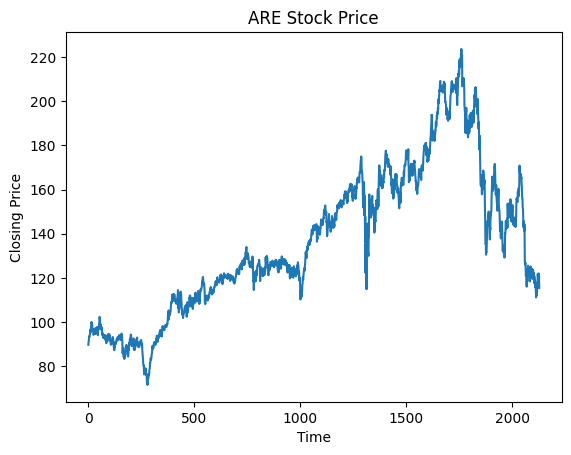

In [72]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [73]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [74]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [75]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [76]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [77]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [78]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [79]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 9s 178ms/step - loss: 0.0261 - val_loss: 0.0555
Epoch 2/100
19/19 [==============================] - 2s 122ms/step - loss: 0.0032 - val_loss: 0.0073
Epoch 3/100
19/19 [==============================] - 3s 133ms/step - loss: 7.9081e-04 - val_loss: 0.0021
Epoch 4/100
19/19 [==============================] - 2s 119ms/step - loss: 5.3721e-04 - val_loss: 0.0016
Epoch 5/100
19/19 [==============================] - 2s 117ms/step - loss: 4.9887e-04 - val_loss: 0.0015
Epoch 6/100
19/19 [==============================] - 2s 125ms/step - loss: 5.0443e-04 - val_loss: 0.0018
Epoch 7/100
19/19 [==============================] - 2s 124ms/step - loss: 4.9913e-04 - val_loss: 0.0016
Epoch 8/100
19/19 [==============================] - 2s 126ms/step - loss: 4.8861e-04 - val_loss: 0.0015
Epoch 9/100
19/19 [==============================] - 2s 123ms/step - loss: 4.9895e-04 - val_loss: 0.0015
Epoch 10/100
19/19 [==============================] - 3s 133ms/

In [80]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

11/11 [==============================] - 0s 19ms/step


In [81]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [82]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [83]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 4.760786930898113
Testing RMSE: 2.988078493085852
Testing MAE: 2.340784439275294
Validation MAE: 3.604051137350819
Testing MAPE: 1.3557814416191354
Validation MAPE: 2.4405676746710103


In [84]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=366
i=0
while(i<30):
    
    if(len(temp_input)>366):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.97538178 0.98189837 0.88862559 0.90962349 0.90409426 0.89632701
 0.90159294 0.9104792  0.90982096 0.91251975 0.89349658 0.88658504
 0.83385993 0.82234071 0.81365192 0.80641127 0.77718536 0.74967088
 0.77613217 0.81088731 0.81378357 0.82457873 0.79081095 0.78304371
 0.76296735 0.75895208 0.78659821 0.74749868 0.75039494 0.73703265
 0.74730121 0.75987362 0.75276461 0.75013165 0.763099   0.75105319
 0.77962085 0.80325171 0.77507899 0.76461295 0.77665877 0.79350974
 0.80970247 0.77534229 0.78429437 0.79357557 0.78811216 0.76869405
 0.76869405 0.78403107 0.78969194 0.80548973 0.81615324 0.80233017
 0.8004871  0.78073986 0.79133755 0.81194049 0.8231306  0.86223012
 0.85854397 0.85308057 0.88414955 0.86525803 0.86288836 0.88599263
 0.86828594 0.86387572 0.83530806 0.82800158 0.83366245 0.81970774
 0.80634544 0.82872565 0.85136914 0.84261453 0.81707478 0.79877567
 0.78297788 0.76178252 0.7819247  0.72742233 0.70102686 0.71656135
 0.74157451 0.70780674 0.69135071 0.62941022 0.602

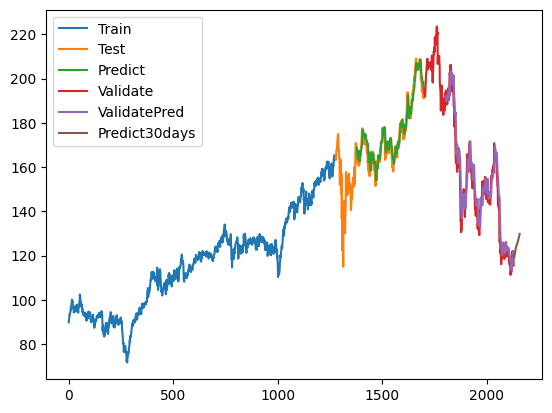

In [85]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [86]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [87]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [88]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [89]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [90]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [91]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [92]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [93]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 6s 131ms/step - loss: 0.1700 - val_loss: 0.0076
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0086 - val_loss: 0.0237
Epoch 3/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0033 - val_loss: 0.0332
Epoch 4/100
19/19 [==============================] - 2s 91ms/step - loss: 0.0024 - val_loss: 0.0296
Epoch 5/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0022 - val_loss: 0.0259
Epoch 6/100
19/19 [==============================] - 2s 96ms/step - loss: 0.0020 - val_loss: 0.0230
Epoch 7/100
19/19 [==============================] - 2s 95ms/step - loss: 0.0019 - val_loss: 0.0201
Epoch 8/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0017 - val_loss: 0.0180
Epoch 9/100
19/19 [==============================] - 2s 91ms/step - loss: 0.0016 - val_loss: 0.0140
Epoch 10/100
19/19 [==============================] - 2s 92ms/step - loss: 0.0014 - val_loss: 0.010

In [94]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

11/11 [==============================] - 0s 18ms/step


In [95]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [96]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [97]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.6762920900784295
Testing RMSE: 0.41668046553588356
Testing MAE: 0.3207086377084992
Validation MAE: 0.4879811629780963
Testing MAPE: 2.694420626761398
Validation MAPE: 4.520913382702968


In [98]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=366
i=0
while(i<30):
    
    if(len(temp_input)>366):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.5880829  0.59585492 0.59909326 0.60103627 0.61334197 0.61010363
 0.625      0.61722798 0.62823834 0.63341969 0.62888601 0.61917098
 0.59779793 0.58549223 0.58031088 0.59196891 0.58549223 0.57707254
 0.5861399  0.60945596 0.60686528 0.59650259 0.58160622 0.58031088
 0.58549223 0.58419689 0.58031088 0.55440415 0.54533679 0.5615285
 0.58031088 0.59196891 0.59196891 0.59779793 0.55958549 0.5388601
 0.55246114 0.56800518 0.57059585 0.56735751 0.59196891 0.59650259
 0.58937824 0.5634715  0.57772021 0.58290155 0.58549223 0.59261658
 0.59585492 0.59974093 0.6107513  0.61658031 0.62759067 0.63147668
 0.63601036 0.62823834 0.63601036 0.65349741 0.64896373 0.66580311
 0.62240933 0.62759067 0.64248705 0.64248705 0.62305699 0.61139896
 0.58290155 0.59391192 0.59974093 0.60686528 0.62564767 0.63018135
 0.62629534 0.60492228 0.62240933 0.61398964 0.59067358 0.58549223
 0.55051813 0.53821244 0.54404145 0.50518135 0.49676166 0.53238342
 0.55505181 0.53238342 0.53108808 0.49676166 0.49546

0 day output [[0.4355975]]
1 day input [0.59585492 0.59909326 0.60103627 0.61334197 0.61010363 0.625
 0.61722798 0.62823834 0.63341969 0.62888601 0.61917098 0.59779793
 0.58549223 0.58031088 0.59196891 0.58549223 0.57707254 0.5861399
 0.60945596 0.60686528 0.59650259 0.58160622 0.58031088 0.58549223
 0.58419689 0.58031088 0.55440415 0.54533679 0.5615285  0.58031088
 0.59196891 0.59196891 0.59779793 0.55958549 0.5388601  0.55246114
 0.56800518 0.57059585 0.56735751 0.59196891 0.59650259 0.58937824
 0.5634715  0.57772021 0.58290155 0.58549223 0.59261658 0.59585492
 0.59974093 0.6107513  0.61658031 0.62759067 0.63147668 0.63601036
 0.62823834 0.63601036 0.65349741 0.64896373 0.66580311 0.62240933
 0.62759067 0.64248705 0.64248705 0.62305699 0.61139896 0.58290155
 0.59391192 0.59974093 0.60686528 0.62564767 0.63018135 0.62629534
 0.60492228 0.62240933 0.61398964 0.59067358 0.58549223 0.55051813
 0.53821244 0.54404145 0.50518135 0.49676166 0.53238342 0.55505181
 0.53238342 0.53108808 0.4967

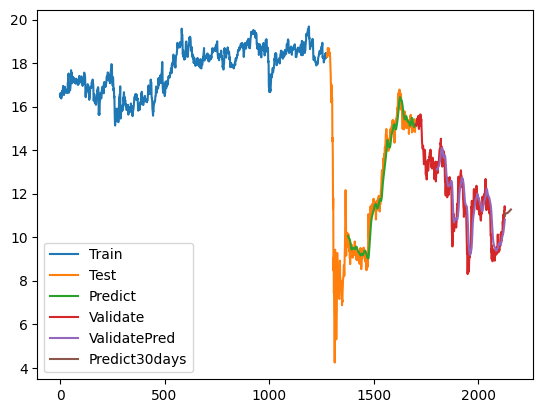

In [99]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [100]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

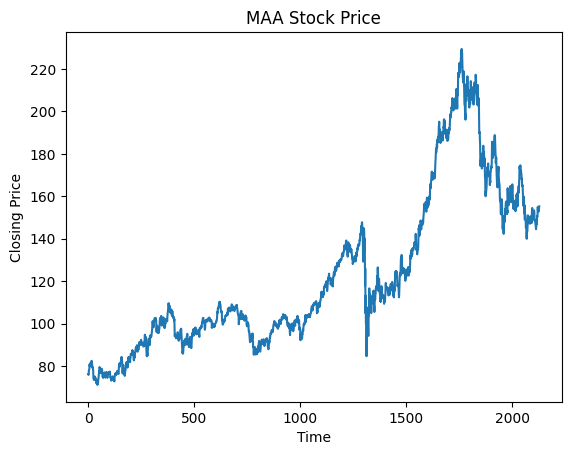

In [101]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [102]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [103]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [104]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [105]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [106]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [107]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [108]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


19/19 [==============================] - 6s 129ms/step - loss: 0.0092 - val_loss: 0.0261
Epoch 2/100
19/19 [==============================] - 2s 90ms/step - loss: 0.0012 - val_loss: 7.8619e-04
Epoch 3/100
19/19 [==============================] - 2s 90ms/step - loss: 4.2833e-04 - val_loss: 8.8872e-04
Epoch 4/100
19/19 [==============================] - 2s 90ms/step - loss: 3.8163e-04 - val_loss: 7.7504e-04
Epoch 5/100
19/19 [==============================] - 2s 90ms/step - loss: 3.6675e-04 - val_loss: 7.8496e-04
Epoch 6/100
19/19 [==============================] - 2s 90ms/step - loss: 3.5058e-04 - val_loss: 7.8517e-04
Epoch 7/100
19/19 [==============================] - 2s 91ms/step - loss: 3.4037e-04 - val_loss: 7.7513e-04
Epoch 8/100
19/19 [==============================] - 2s 91ms/step - loss: 3.3419e-04 - val_loss: 7.5891e-04
Epoch 9/100
19/19 [==============================] - 2s 91ms/step - loss: 3.2952e-04 - val_loss: 8.0168e-04
Epoch 10/100
19/19 [==============================]

In [109]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

11/11 [==============================] - 0s 18ms/step


In [110]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [111]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [112]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.5791174925013403
Testing RMSE: 2.47683229909786
Testing MAE: 1.941947294635537
Validation MAE: 2.810384216308594
Testing MAPE: 1.3467912163383262
Validation MAPE: 1.652459699316216


In [113]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=366
i=0
while(i<30):
    
    if(len(temp_input)>366):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.97908901 0.98704909 0.96070504 0.94604839 0.91774591 0.90687978
 0.89980416 0.91970434 0.93347653 0.90946996 0.90346832 0.87188073
 0.83896645 0.83226988 0.83170131 0.80889507 0.80763156 0.78950028
 0.84408364 0.85621328 0.84717923 0.890012   0.89626635 0.89317076
 0.87927222 0.87472361 0.91850401 0.88666372 0.88243098 0.86189905
 0.86676354 0.86872197 0.84616843 0.84206204 0.85071704 0.82551014
 0.84130394 0.87661886 0.84313602 0.83694485 0.8632889  0.87826142
 0.90410007 0.89013835 0.86568956 0.88792722 0.88457894 0.86752164
 0.84825321 0.84926401 0.8635416  0.87503948 0.85678186 0.85810853
 0.84863226 0.83435467 0.84686335 0.85419167 0.87522901 0.89974098
 0.89620317 0.87371281 0.8981616  0.88262051 0.88527386 0.9231158
 0.91553478 0.9045423  0.86373113 0.86246762 0.85292817 0.84806368
 0.83410196 0.86145682 0.88028302 0.89272854 0.85867711 0.8457262
 0.83549182 0.82961653 0.85273864 0.79303809 0.74951039 0.74913134
 0.75273233 0.7278413  0.7164066  0.67212079 0.65152

0 day output [[0.5253036]]
1 day input [0.98704909 0.96070504 0.94604839 0.91774591 0.90687978 0.89980416
 0.91970434 0.93347653 0.90946996 0.90346832 0.87188073 0.83896645
 0.83226988 0.83170131 0.80889507 0.80763156 0.78950028 0.84408364
 0.85621328 0.84717923 0.890012   0.89626635 0.89317076 0.87927222
 0.87472361 0.91850401 0.88666372 0.88243098 0.86189905 0.86676354
 0.86872197 0.84616843 0.84206204 0.85071704 0.82551014 0.84130394
 0.87661886 0.84313602 0.83694485 0.8632889  0.87826142 0.90410007
 0.89013835 0.86568956 0.88792722 0.88457894 0.86752164 0.84825321
 0.84926401 0.8635416  0.87503948 0.85678186 0.85810853 0.84863226
 0.83435467 0.84686335 0.85419167 0.87522901 0.89974098 0.89620317
 0.87371281 0.8981616  0.88262051 0.88527386 0.9231158  0.91553478
 0.9045423  0.86373113 0.86246762 0.85292817 0.84806368 0.83410196
 0.86145682 0.88028302 0.89272854 0.85867711 0.8457262  0.83549182
 0.82961653 0.85273864 0.79303809 0.74951039 0.74913134 0.75273233
 0.7278413  0.7164066  

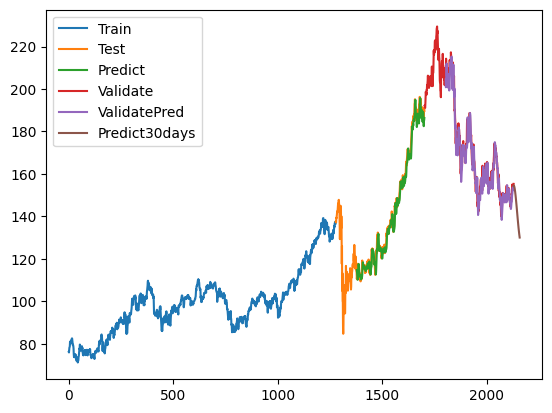

In [114]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()